
📊 Estatísticas Descritivas:
              Open         High          Low        Close        Volume  \
count  4363.000000  4363.000000  4363.000000  4363.000000   4363.000000   
mean     78.615728    79.590445    77.588941    78.618338  18688.370617   
std      24.228538    24.338900    24.105584    24.247406  16670.006626   
min      19.559999    21.270000    16.000000    19.330000      0.000000   
25%      60.310001    61.160000    59.225000    60.225000   1333.500000   
50%      76.730003    77.629997    75.669998    76.769997  19073.000000   
75%     100.014999   101.290001    98.490002   100.064999  31312.000000   
max     146.080002   147.429993   144.270004   146.080002  92049.000000   

            Target  
count  4363.000000  
mean     78.618109  
std      24.247438  
min      19.330000  
25%      60.225000  
50%      76.769997  
75%     100.064999  
max     146.080002  


<Figure size 1200x600 with 0 Axes>

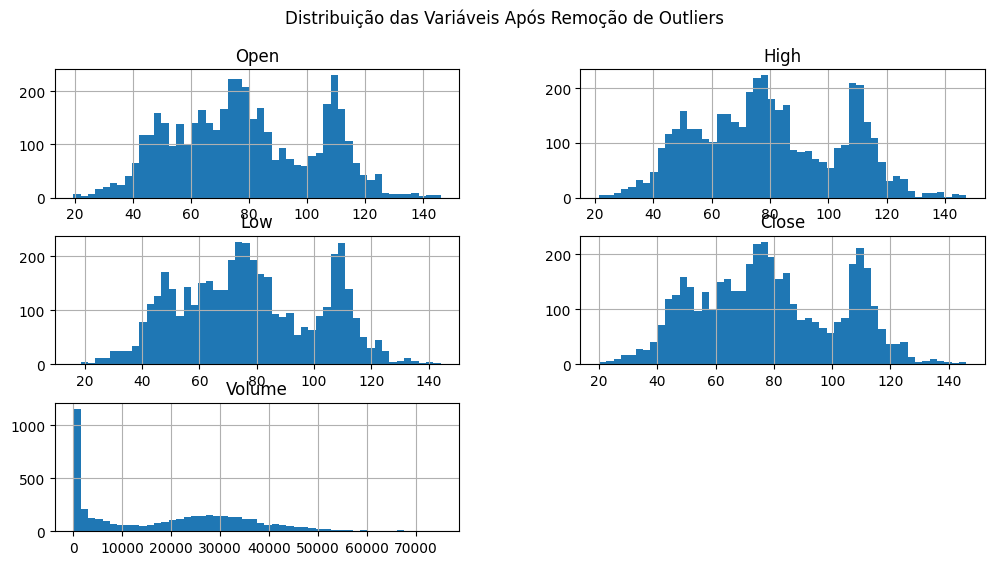

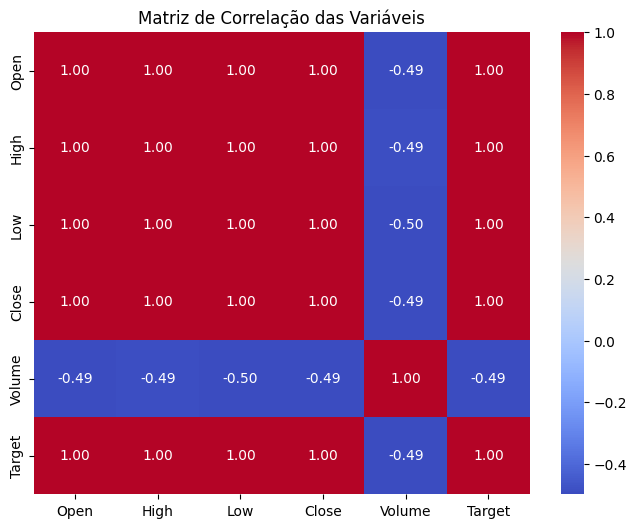

c:\Users\HomePC\dashboard-petroleo\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



➡️ Avaliação dos Modelos de Machine Learning:
🔹 Modelo: XGBoost
MAE: 1.64
RMSE: 2.36
R²: 95.76%

🔹 Modelo: Random Forest
MAE: 1.61
RMSE: 2.25
R²: 96.16%

🔹 Modelo: Regressão Linear
MAE: 1.45
RMSE: 2.07
R²: 96.77%


➡️ Treinando LSTM...
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2343.5359
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0206
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2777
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4909
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0136
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1466
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0947
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0361
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9337
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3872
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

🔹 Modelo: LSTM
MAE: 1.67
RMSE: 2.32
R²: 95.92%



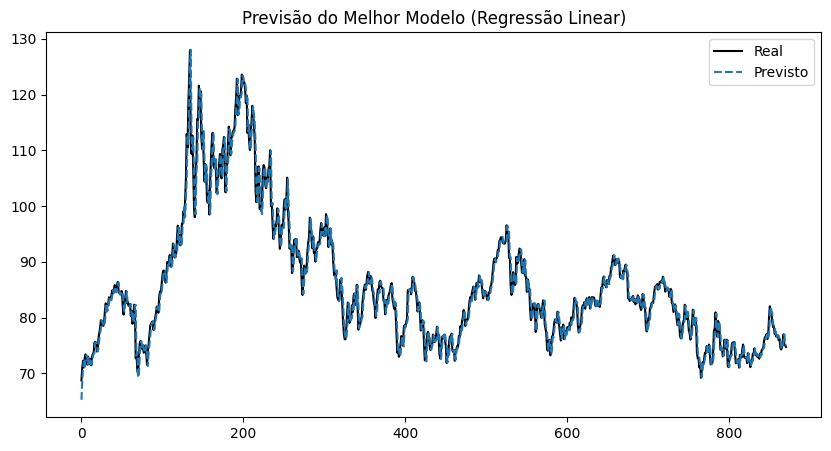

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🔹 Baixar os dados históricos do Brent Crude Oil
brent_data = yf.Ticker("BZ=F")
brent_df = pd.DataFrame(brent_data.history(period="max"))

# 🔹 Ajustar a data para remover a hora e resetar índice
brent_df.reset_index(inplace=True)
brent_df['Date'] = brent_df['Date'].dt.strftime('%Y-%m-%d')

# 🔹 Selecionar colunas de interesse
brent_df = brent_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 🔹 Criar target (preço de fechamento do próximo dia)
brent_df['Target'] = brent_df['Close'].shift(-1)

# 🔹 Remover NaN gerado pelo shift
brent_df.dropna(inplace=True)

# 🔹 Estatísticas Descritivas
print("\n📊 Estatísticas Descritivas:")
print(brent_df.describe())

# 🔹 Detectar e corrigir outliers usando o método do IQR
def remove_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Aplicar a remoção de outliers nas variáveis numéricas
brent_df = remove_outliers(brent_df, ['Open', 'High', 'Low', 'Close', 'Volume'])

# 🔹 Visualização da Distribuição das Variáveis
plt.figure(figsize=(12, 6))
brent_df[['Open', 'High', 'Low', 'Close', 'Volume']].hist(bins=50, figsize=(12, 6))
plt.suptitle("Distribuição das Variáveis Após Remoção de Outliers")
plt.show()

# 🔹 Matriz de Correlação
plt.figure(figsize=(8, 6))
sns.heatmap(brent_df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Variáveis")
plt.show()

# 🔹 Selecionar variáveis significativas com base na correlação
# Remover 'Volume' devido à baixa correlação com o Target
X = brent_df[['Open', 'High', 'Low', 'Close']]
y = brent_df['Target']

# 🔹 Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🔹 Definir modelos de ML
models = {
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Regressão Linear": LinearRegression(),
}

# 🔹 Criar modelo LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# 🔹 Função para treinar e avaliar modelos
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ajustar tamanho caso necessário
    min_length = min(len(y_test), len(y_pred))
    y_test, y_pred = y_test[:min_length], y_pred[:min_length]

    # Calcular métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"🔹 Modelo: {model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2%}\n")

    return {"MAE": mae, "RMSE": rmse, "R2": r2, "pred": y_pred}

# 🔹 Avaliar modelos clássicos
print("\n➡️ Avaliação dos Modelos de Machine Learning:")
results = {name: train_and_evaluate(model, X_train, X_test, y_train, y_test, name) for name, model in models.items()}

# 🔹 Treinar e avaliar LSTM
print("\n➡️ Treinando LSTM...")
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ajustar tamanho se necessário
min_length = min(len(y_test), len(y_pred_lstm))
y_test, y_pred_lstm = y_test[:min_length], y_pred_lstm[:min_length]

r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"\n🔹 Modelo: LSTM")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.2%}\n")

# 🔹 Comparar os modelos
all_results = {**results, "LSTM": {"MAE": mae_lstm, "RMSE": rmse_lstm, "R2": r2_lstm, "pred": y_pred_lstm}}
best_model = max(all_results, key=lambda k: all_results[k]["R2"])

print(f"🏆 Melhor modelo: {best_model} com R² de {all_results[best_model]['R2']:.2%}")

# 🔹 Plotar previsões do melhor modelo
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black")
plt.plot(all_results[best_model]['pred'], label="Previsto", linestyle="dashed")
plt.legend()
plt.title(f"Previsão do Melhor Modelo ({best_model})")
plt.show()


📈 Períodos de Alta Variação:
            Date       Close  Daily Change (%)
216   2008-06-06  137.690002          7.958289
269   2008-08-21  120.160004          5.071706
270   2008-08-22  113.919998         -5.193080
276   2008-09-02  108.339996         -5.006582
286   2008-09-16   89.220001         -5.326822
...          ...         ...               ...
4026  2023-10-13   90.889999          5.686046
4164  2024-05-01   83.440002         -5.030729
4249  2024-09-03   73.750000         -6.408633
4271  2024-10-03   77.620003          5.033831
4288  2024-10-28   71.419998         -6.088106

[185 rows x 3 columns]


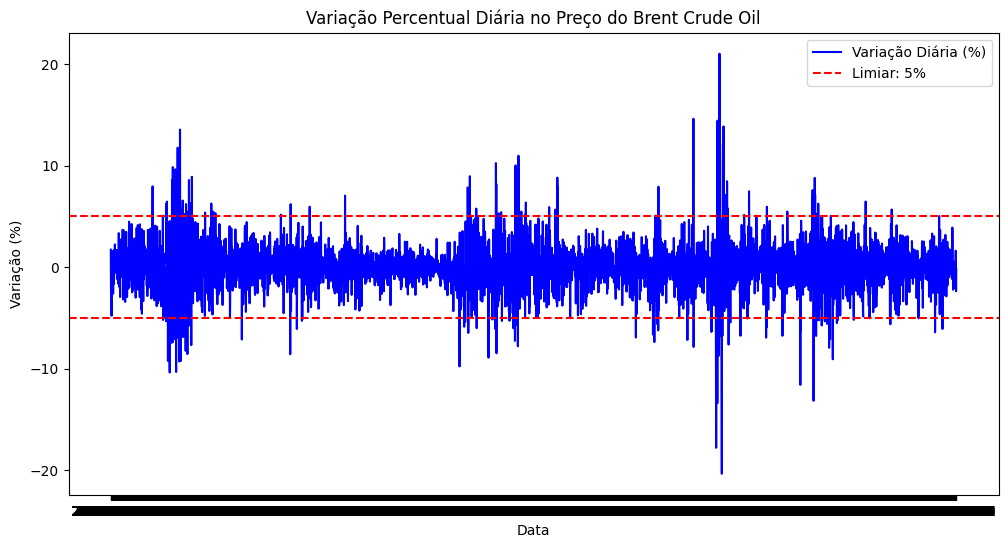

In [2]:
# Calcular variação percentual diária
brent_df['Daily Change (%)'] = brent_df['Close'].pct_change() * 100

# Definir limiar para alta variação (exemplo: 5%)
threshold = 5
high_variation_periods = brent_df[brent_df['Daily Change (%)'].abs() > threshold]

# Exibir períodos de alta variação
print("\n📈 Períodos de Alta Variação:")
print(high_variation_periods[['Date', 'Close', 'Daily Change (%)']])

# Plotar variação diária
plt.figure(figsize=(12, 6))
plt.plot(brent_df['Date'], brent_df['Daily Change (%)'], label="Variação Diária (%)", color="blue")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Limiar: {threshold}%")
plt.axhline(y=-threshold, color='red', linestyle='--')
plt.title("Variação Percentual Diária no Preço do Brent Crude Oil")
plt.xlabel("Data")
plt.ylabel("Variação (%)")
plt.legend()
plt.show()

In [3]:
# 🔹 Filtrar os períodos de alta variação
high_variation_dates = [
    '2008-06-06', '2008-08-21', '2008-08-22', '2008-09-02', '2008-09-16', 
    '2023-10-13', '2024-05-01', '2024-09-03', '2024-10-03', '2024-10-28'
]

# Filtrar o DataFrame para os períodos de alta variação
high_variation_df = brent_df[brent_df['Date'].astype(str).isin(high_variation_dates)]

# 🔹 Separar features (X) e target (y) nos dados filtrados
X_high_var = high_variation_df[['Open', 'High', 'Low', 'Close', 'Volume']]
y_high_var = high_variation_df['Target']

# Dividir em treino e teste para os períodos de alta variação
X_train_high_var, X_test_high_var, y_train_high_var, y_test_high_var = train_test_split(
    X_high_var, y_high_var, test_size=0.2, shuffle=False
)

# Mostrar os períodos de treino e teste nos dados de alta variação
train_start_date_high_var = high_variation_df.iloc[:len(X_train_high_var)]['Date'].min()
train_end_date_high_var = high_variation_df.iloc[:len(X_train_high_var)]['Date'].max()
test_start_date_high_var = high_variation_df.iloc[len(X_train_high_var):]['Date'].min()
test_end_date_high_var = high_variation_df.iloc[len(X_train_high_var):]['Date'].max()

print(f"📅 Período de Treino (Alta Variação): {train_start_date_high_var} a {train_end_date_high_var}")
print(f"📅 Período de Teste (Alta Variação): {test_start_date_high_var} a {test_end_date_high_var}")

# 🔹 Treinar e avaliar os modelos nos períodos de alta variação
print("\n➡️ Avaliação dos Modelos nos Períodos de Alta Variação:")
results_high_variation = {
    name: train_and_evaluate(model, X_train_high_var, X_test_high_var, y_train_high_var, y_test_high_var, name)
    for name, model in models.items()
}

📅 Período de Treino (Alta Variação): 2008-06-06 a 2024-09-03
📅 Período de Teste (Alta Variação): 2024-10-03 a 2024-10-28

➡️ Avaliação dos Modelos nos Períodos de Alta Variação:
🔹 Modelo: XGBoost
MAE: 3.47
RMSE: 3.94
R²: -29.56%

🔹 Modelo: Random Forest
MAE: 4.47
RMSE: 6.19
R²: -219.29%

🔹 Modelo: Regressão Linear
MAE: 6.21
RMSE: 7.19
R²: -330.44%



In [4]:
# Comparar resultados gerais e de alta variação
print("\n📊 Comparação de Resultados:")
for model_name in results:
    print(f"Modelo: {model_name}")
    print(f"R² Geral: {results[model_name]['R2']:.2%}")
    print(f"R² Alta Variação: {results_high_variation[model_name]['R2']:.2%}")
    print("-" * 30)


📊 Comparação de Resultados:
Modelo: XGBoost
R² Geral: 95.76%
R² Alta Variação: -29.56%
------------------------------
Modelo: Random Forest
R² Geral: 96.16%
R² Alta Variação: -219.29%
------------------------------
Modelo: Regressão Linear
R² Geral: 96.77%
R² Alta Variação: -330.44%
------------------------------


In [5]:
# 🔹 Treinar e Avaliar nos Períodos de Alta Variação
# Dividir os períodos de alta variação em treino e teste
X_train_high_var, X_test_high_var, y_train_high_var, y_test_high_var = train_test_split(
    X_high_var, y_high_var, test_size=0.2, shuffle=False
)

# Treinar e avaliar os modelos nos períodos de alta variação
print("\n➡️ Avaliação dos Modelos Treinados em Períodos de Alta Variação:")
results_high_var_training = {
    name: train_and_evaluate(model, X_train_high_var, X_test_high_var, y_train_high_var, y_test_high_var, name)
    for name, model in models.items()
}


➡️ Avaliação dos Modelos Treinados em Períodos de Alta Variação:
🔹 Modelo: XGBoost
MAE: 3.47
RMSE: 3.94
R²: -29.56%

🔹 Modelo: Random Forest
MAE: 5.10
RMSE: 6.80
R²: -285.11%

🔹 Modelo: Regressão Linear
MAE: 6.21
RMSE: 7.19
R²: -330.44%



In [7]:
# Comparar resultados gerais, alta variação (teste) e alta variação (treino e teste)
print("\n📊 Comparação de Resultados:")
for model_name in results:
    print(f"Modelo: {model_name}")
    print(f"R² Geral: {results[model_name]['R2']:.2%}")
    print(f"R² Alta Variação (Teste): {results_high_variation[model_name]['R2']:.2%}")
    print(f"R² Alta Variação (Treino e Teste): {results_high_var_training[model_name]['R2']:.2%}")
    print("-" * 30)


📊 Comparação de Resultados:
Modelo: XGBoost
R² Geral: 95.76%
R² Alta Variação (Teste): -29.56%
R² Alta Variação (Treino e Teste): -29.56%
------------------------------
Modelo: Random Forest
R² Geral: 96.16%
R² Alta Variação (Teste): -219.29%
R² Alta Variação (Treino e Teste): -153.07%
------------------------------
Modelo: Regressão Linear
R² Geral: 96.77%
R² Alta Variação (Teste): -330.44%
R² Alta Variação (Treino e Teste): -330.44%
------------------------------


In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🔹 Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_high_var)

# 🔹 Criar sequências de entrada e saída para o LSTM
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Configurar o comprimento da sequência
seq_length = 10  # Número de dias anteriores usados para previsão
X_lstm, y_lstm = create_sequences(scaled_data, y_high_var.values, seq_length)

# Dividir em treino e teste
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

In [10]:
print(f"Forma de X_lstm: {X_lstm.shape}")

Forma de X_lstm: (0,)


In [11]:
print(f"Número de linhas em X_high_var: {len(X_high_var)}")

Número de linhas em X_high_var: 10


In [9]:
# 🔹 Criar o modelo LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X_lstm.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)  # Saída com apenas 1 valor (preço do próximo dia)
])

# Compilar o modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 🔹 Treinar o modelo
history = model_lstm.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=50, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

IndexError: tuple index out of range


📊 Estatísticas Descritivas:
              Open         High          Low        Close        Volume  \
count  4363.000000  4363.000000  4363.000000  4363.000000   4363.000000   
mean     78.615728    79.590445    77.588941    78.618338  18688.370617   
std      24.228538    24.338900    24.105584    24.247406  16670.006626   
min      19.559999    21.270000    16.000000    19.330000      0.000000   
25%      60.310001    61.160000    59.225000    60.225000   1333.500000   
50%      76.730003    77.629997    75.669998    76.769997  19073.000000   
75%     100.014999   101.290001    98.490002   100.064999  31312.000000   
max     146.080002   147.429993   144.270004   146.080002  92049.000000   

            Target  
count  4363.000000  
mean     78.618109  
std      24.247438  
min      19.330000  
25%      60.225000  
50%      76.769997  
75%     100.064999  
max     146.080002  


<Figure size 1200x600 with 0 Axes>

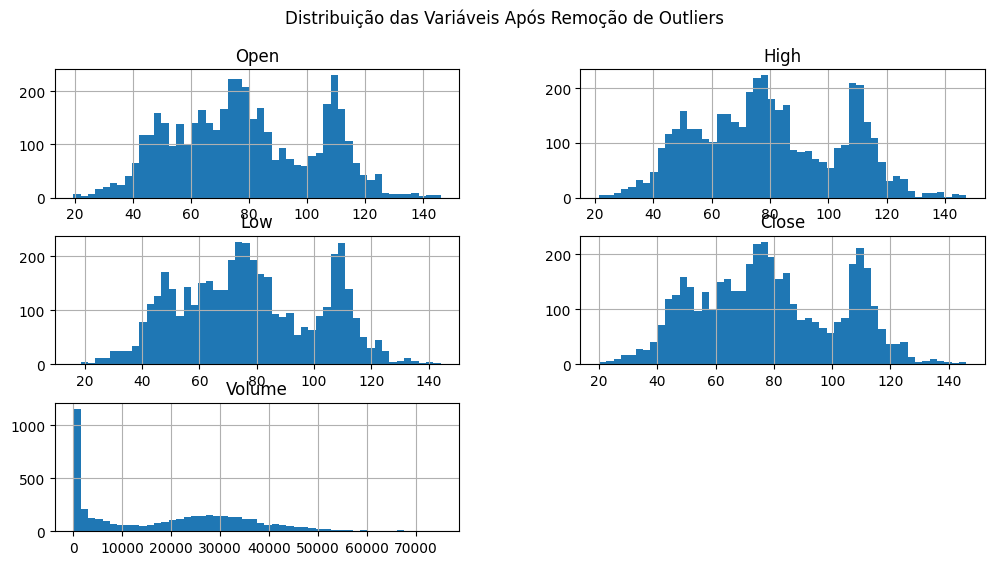

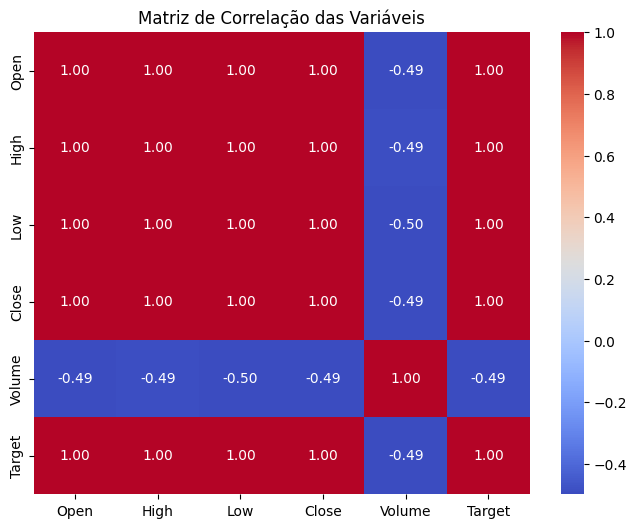

c:\Users\HomePC\dashboard-petroleo\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



➡️ Avaliação dos Modelos de Machine Learning:
🔹 Modelo: XGBoost
MAE: 1.64
RMSE: 2.36
R²: 95.76%

🔹 Modelo: Random Forest
MAE: 1.61
RMSE: 2.25
R²: 96.16%

🔹 Modelo: Regressão Linear
MAE: 1.45
RMSE: 2.07
R²: 96.77%


➡️ Treinando LSTM...
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3148.6550
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5384
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2245
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1723
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4188
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3012
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3630
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1491
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4432
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2226
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

🔹 Modelo: LSTM
MAE: 1.76
RMSE: 2.49
R²: 95.31%



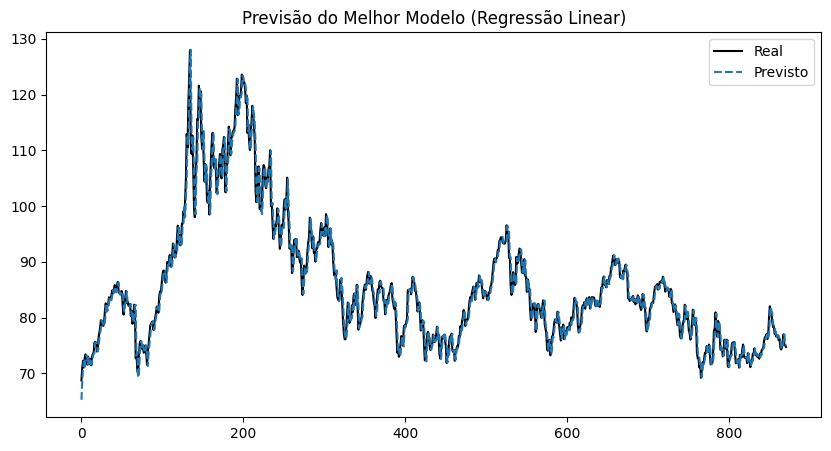

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🔹 Baixar os dados históricos do Brent Crude Oil
brent_data = yf.Ticker("BZ=F")
brent_df = pd.DataFrame(brent_data.history(period="max"))

# 🔹 Ajustar a data para remover a hora e resetar índice
brent_df.reset_index(inplace=True)
brent_df['Date'] = brent_df['Date'].dt.strftime('%Y-%m-%d')

# 🔹 Selecionar colunas de interesse
brent_df = brent_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 🔹 Criar target (preço de fechamento do próximo dia)
brent_df['Target'] = brent_df['Close'].shift(-1)

# 🔹 Remover NaN gerado pelo shift
brent_df.dropna(inplace=True)

# 🔹 Estatísticas Descritivas
print("\n📊 Estatísticas Descritivas:")
print(brent_df.describe())

# 🔹 Detectar e corrigir outliers usando o método do IQR
def remove_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Aplicar a remoção de outliers nas variáveis numéricas
brent_df = remove_outliers(brent_df, ['Open', 'High', 'Low', 'Close', 'Volume'])

# 🔹 Visualização da Distribuição das Variáveis
plt.figure(figsize=(12, 6))
brent_df[['Open', 'High', 'Low', 'Close', 'Volume']].hist(bins=50, figsize=(12, 6))
plt.suptitle("Distribuição das Variáveis Após Remoção de Outliers")
plt.show()

# 🔹 Matriz de Correlação
plt.figure(figsize=(8, 6))
sns.heatmap(brent_df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Variáveis")
plt.show()

# 🔹 Selecionar variáveis significativas com base na correlação
# Remover 'Volume' devido à baixa correlação com o Target
X = brent_df[['Open', 'High', 'Low', 'Close']]
y = brent_df['Target']

# 🔹 Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🔹 Definir modelos de ML
models = {
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Regressão Linear": LinearRegression(),
}

# 🔹 Criar modelo LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# 🔹 Função para treinar e avaliar modelos
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ajustar tamanho caso necessário
    min_length = min(len(y_test), len(y_pred))
    y_test, y_pred = y_test[:min_length], y_pred[:min_length]

    # Calcular métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"🔹 Modelo: {model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2%}\n")

    return {"MAE": mae, "RMSE": rmse, "R2": r2, "pred": y_pred}

# 🔹 Avaliar modelos clássicos
print("\n➡️ Avaliação dos Modelos de Machine Learning:")
results = {name: train_and_evaluate(model, X_train, X_test, y_train, y_test, name) for name, model in models.items()}

# 🔹 Treinar e avaliar LSTM
print("\n➡️ Treinando LSTM...")
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ajustar tamanho se necessário
min_length = min(len(y_test), len(y_pred_lstm))
y_test, y_pred_lstm = y_test[:min_length], y_pred_lstm[:min_length]

r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"\n🔹 Modelo: LSTM")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.2%}\n")

# 🔹 Comparar os modelos
all_results = {**results, "LSTM": {"MAE": mae_lstm, "RMSE": rmse_lstm, "R2": r2_lstm, "pred": y_pred_lstm}}
best_model = max(all_results, key=lambda k: all_results[k]["R2"])

print(f"🏆 Melhor modelo: {best_model} com R² de {all_results[best_model]['R2']:.2%}")

# 🔹 Plotar previsões do melhor modelo
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black")
plt.plot(all_results[best_model]['pred'], label="Previsto", linestyle="dashed")
plt.legend()
plt.title(f"Previsão do Melhor Modelo ({best_model})")
plt.show()


📊 Estatísticas Descritivas:
              Open         High          Low        Close        Volume  \
count  4363.000000  4363.000000  4363.000000  4363.000000   4363.000000   
mean     78.615728    79.590445    77.588941    78.618338  18688.370617   
std      24.228538    24.338900    24.105584    24.247406  16670.006626   
min      19.559999    21.270000    16.000000    19.330000      0.000000   
25%      60.310001    61.160000    59.225000    60.225000   1333.500000   
50%      76.730003    77.629997    75.669998    76.769997  19073.000000   
75%     100.014999   101.290001    98.490002   100.064999  31312.000000   
max     146.080002   147.429993   144.270004   146.080002  92049.000000   

            Target  
count  4363.000000  
mean     78.618109  
std      24.247438  
min      19.330000  
25%      60.225000  
50%      76.769997  
75%     100.064999  
max     146.080002  


<Figure size 1200x600 with 0 Axes>

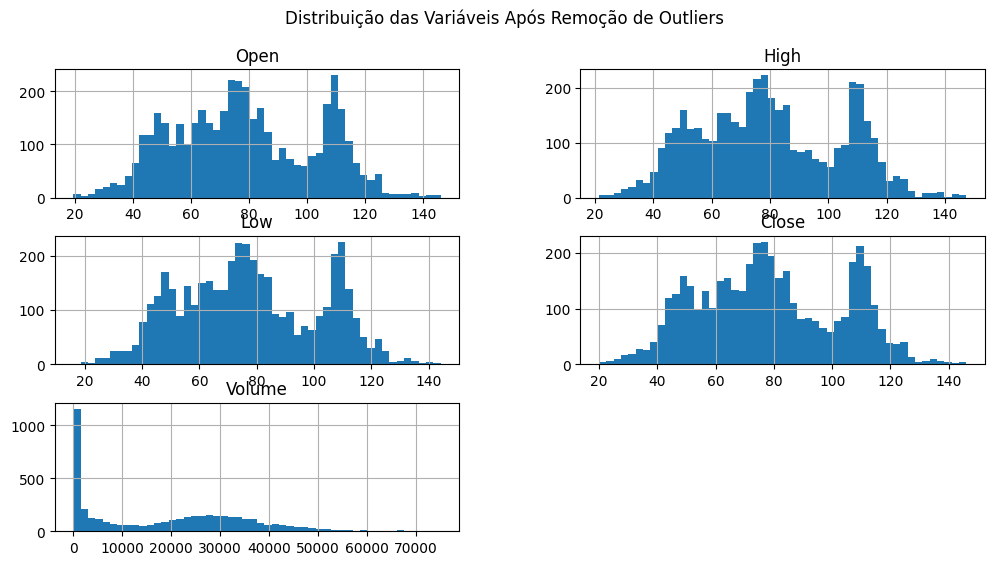

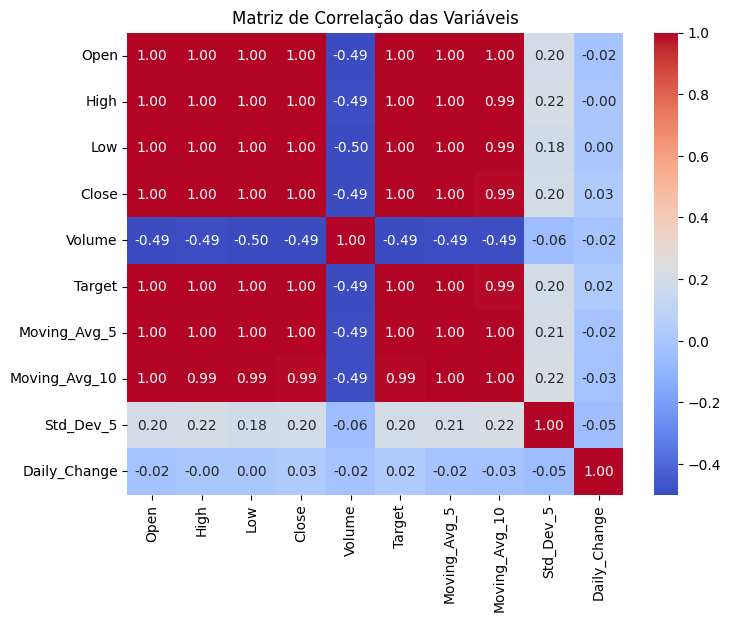


📅 Período de Treino: 2007-08-10 a 2021-08-23
📅 Período de Teste: 2021-08-24 a 2025-02-13

➡️ Avaliação dos Modelos de Machine Learning:


c:\Users\HomePC\dashboard-petroleo\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔹 Modelo: XGBoost
MAE: 1.69
RMSE: 2.36
R²: 95.76%

🔹 Modelo: Random Forest
MAE: 1.62
RMSE: 2.27
R²: 96.07%

🔹 Modelo: Regressão Linear
MAE: 1.45
RMSE: 2.07
R²: 96.75%


➡️ Treinando LSTM...
Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2482.1956
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 200.1563
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 151.5062
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 124.4583
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 113.1090
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 109.2066
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 104.8416
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 95.2750
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 97.2318
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93.1367
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 85.9294
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

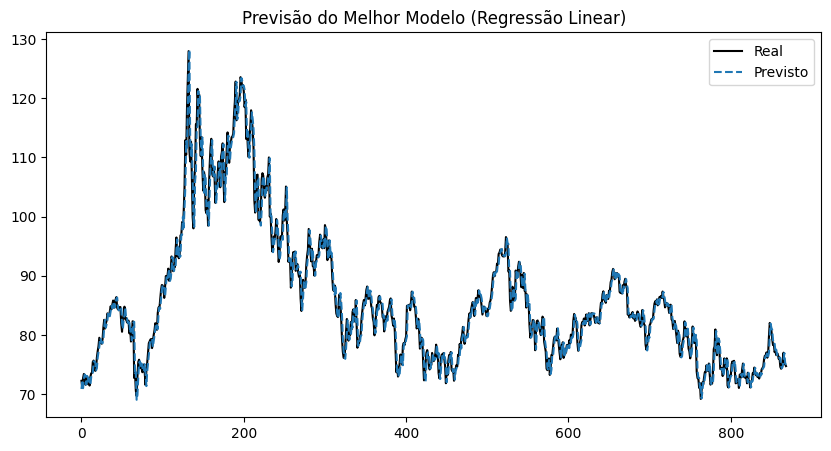

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 🔹 Baixar os dados históricos do Brent Crude Oil
brent_data = yf.Ticker("BZ=F")
brent_df = pd.DataFrame(brent_data.history(period="max"))

# 🔹 Ajustar a data para remover a hora e resetar índice
brent_df.reset_index(inplace=True)
brent_df['Date'] = brent_df['Date'].dt.strftime('%Y-%m-%d')

# 🔹 Selecionar colunas de interesse
brent_df = brent_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 🔹 Criar target (preço de fechamento do próximo dia)
brent_df['Target'] = brent_df['Close'].shift(-1)

# 🔹 Remover NaN gerado pelo shift
brent_df.dropna(inplace=True)

# 🔹 Estatísticas Descritivas
print("\n📊 Estatísticas Descritivas:")
print(brent_df.describe())

# 🔹 Detectar e corrigir outliers usando o método do IQR
def remove_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Aplicar a remoção de outliers nas variáveis numéricas
brent_df = remove_outliers(brent_df, ['Open', 'High', 'Low', 'Close', 'Volume'])

# 🔹 Adicionar Features Derivadas
brent_df['Moving_Avg_5'] = brent_df['Close'].rolling(window=5).mean()
brent_df['Moving_Avg_10'] = brent_df['Close'].rolling(window=10).mean()
brent_df['Std_Dev_5'] = brent_df['Close'].rolling(window=5).std()
brent_df['Daily_Change'] = brent_df['Close'].pct_change() * 100

# Substituir NaN gerado pelas novas features
brent_df.dropna(inplace=True)

# 🔹 Visualização da Distribuição das Variáveis
plt.figure(figsize=(12, 6))
brent_df[['Open', 'High', 'Low', 'Close', 'Volume']].hist(bins=50, figsize=(12, 6))
plt.suptitle("Distribuição das Variáveis Após Remoção de Outliers")
plt.show()

# 🔹 Matriz de Correlação
plt.figure(figsize=(8, 6))
sns.heatmap(brent_df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Variáveis")
plt.show()

# 🔹 Selecionar variáveis relevantes
X = brent_df[['Open', 'High', 'Low', 'Close', 'Moving_Avg_5', 'Moving_Avg_10', 'Std_Dev_5']]
y = brent_df['Target']

# 🔹 Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Exibir período de treino e teste
train_start_date = brent_df.iloc[:len(X_train)]['Date'].min()
train_end_date = brent_df.iloc[:len(X_train)]['Date'].max()
test_start_date = brent_df.iloc[len(X_train):]['Date'].min()
test_end_date = brent_df.iloc[len(X_train):]['Date'].max()

print(f"\n📅 Período de Treino: {train_start_date} a {train_end_date}")
print(f"📅 Período de Teste: {test_start_date} a {test_end_date}")

# 🔹 Definir modelos de ML
models = {
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Regressão Linear": LinearRegression(),
}

# 🔹 Criar modelo LSTM com Dropout
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# 🔹 Função para treinar e avaliar modelos
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ajustar tamanho caso necessário
    min_length = min(len(y_test), len(y_pred))
    y_test, y_pred = y_test[:min_length], y_pred[:min_length]

    # Calcular métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"🔹 Modelo: {model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2%}\n")

    return {"MAE": mae, "RMSE": rmse, "R2": r2, "pred": y_pred}

# 🔹 Avaliar modelos clássicos
print("\n➡️ Avaliação dos Modelos de Machine Learning:")
results = {name: train_and_evaluate(model, X_train, X_test, y_train, y_test, name) for name, model in models.items()}

# 🔹 Treinar e avaliar LSTM
print("\n➡️ Treinando LSTM...")
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ajustar tamanho se necessário
min_length = min(len(y_test), len(y_pred_lstm))
y_test, y_pred_lstm = y_test[:min_length], y_pred_lstm[:min_length]

r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"\n🔹 Modelo: LSTM")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.2%}\n")

# 🔹 Comparar os modelos
all_results = {**results, "LSTM": {"MAE": mae_lstm, "RMSE": rmse_lstm, "R2": r2_lstm, "pred": y_pred_lstm}}
best_model = max(all_results, key=lambda k: all_results[k]["R2"])

print(f"🏆 Melhor modelo: {best_model} com R² de {all_results[best_model]['R2']:.2%}")

# 🔹 Plotar previsões do melhor modelo
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black")
plt.plot(all_results[best_model]['pred'], label="Previsto", linestyle="dashed")
plt.legend()
plt.title(f"Previsão do Melhor Modelo ({best_model})")
plt.show()


📊 Estatísticas Descritivas:
              Open         High          Low        Close        Volume  \
count  4363.000000  4363.000000  4363.000000  4363.000000   4363.000000   
mean     78.615728    79.590445    77.588941    78.618338  18688.370617   
std      24.228538    24.338900    24.105584    24.247406  16670.006626   
min      19.559999    21.270000    16.000000    19.330000      0.000000   
25%      60.310001    61.160000    59.225000    60.225000   1333.500000   
50%      76.730003    77.629997    75.669998    76.769997  19073.000000   
75%     100.014999   101.290001    98.490002   100.064999  31312.000000   
max     146.080002   147.429993   144.270004   146.080002  92049.000000   

            Target  
count  4363.000000  
mean     78.618070  
std      24.247444  
min      19.330000  
25%      60.225000  
50%      76.769997  
75%     100.064999  
max     146.080002  


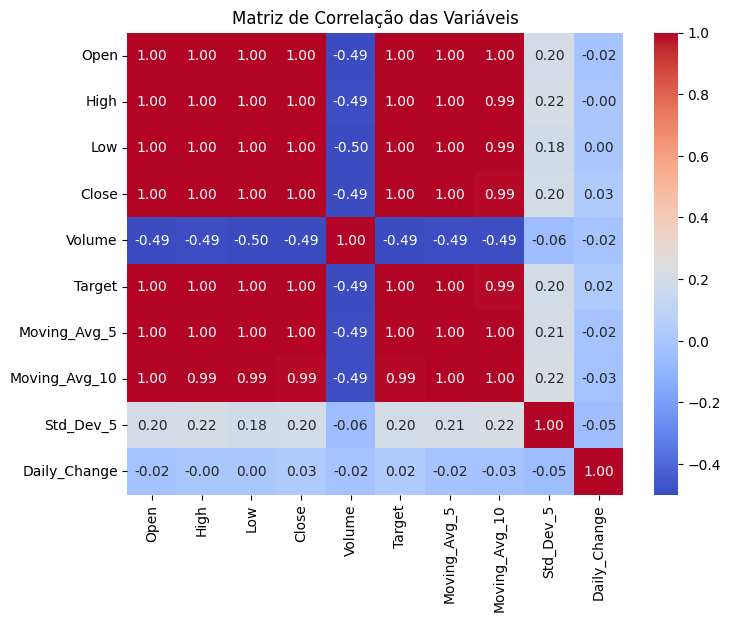


📅 Período de Treino: 2007-08-10 a 2021-08-23
📅 Período de Teste: 2021-08-24 a 2025-02-13

➡️ Avaliação dos Modelos de Machine Learning:


c:\Users\HomePC\dashboard-petroleo\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔹 Modelo: XGBoost
MAE: 1.69
RMSE: 2.36
R²: 95.76%



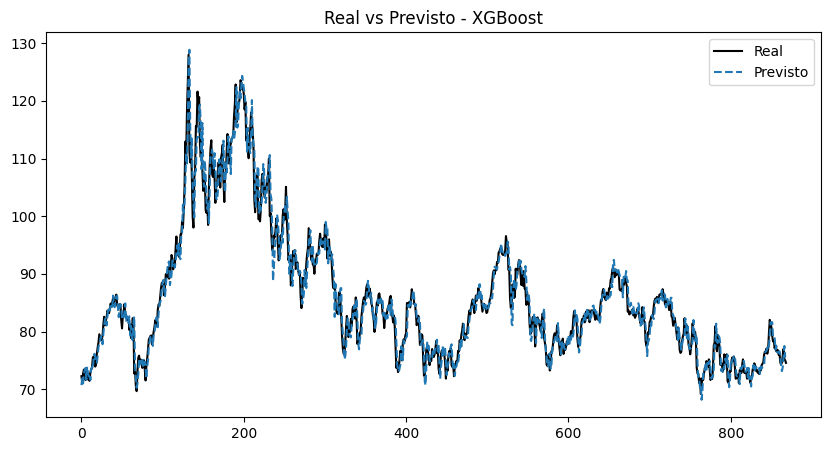

🔹 Modelo: Random Forest
MAE: 1.61
RMSE: 2.27
R²: 96.10%



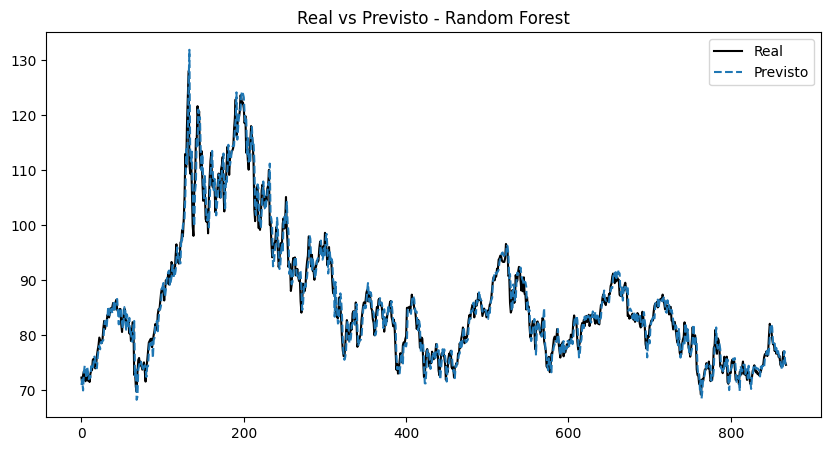

🔹 Modelo: Regressão Linear
MAE: 1.46
RMSE: 2.07
R²: 96.75%



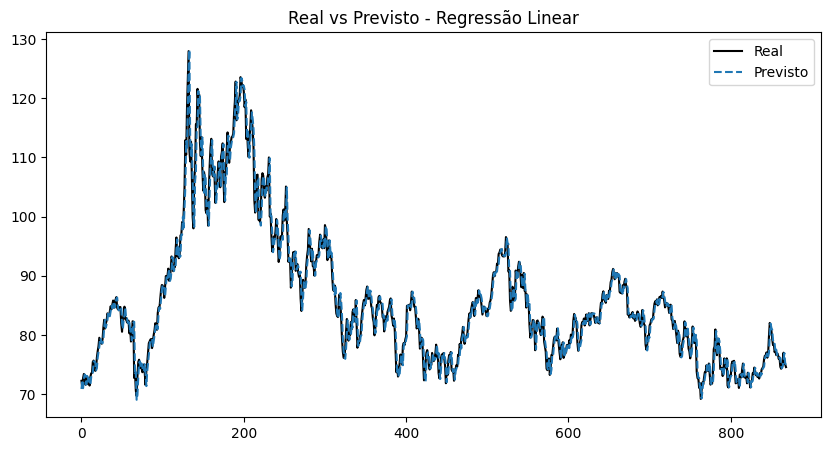


➡️ Treinando LSTM...
Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2510.8535
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 139.7466
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 98.0798
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 86.7589
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 88.9067
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 81.6466
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 73.8395
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 73.1170
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 74.8883
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 68.5858
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.7975
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69.8056
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.1277
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 64.0519
Epoch 15/20
109/10

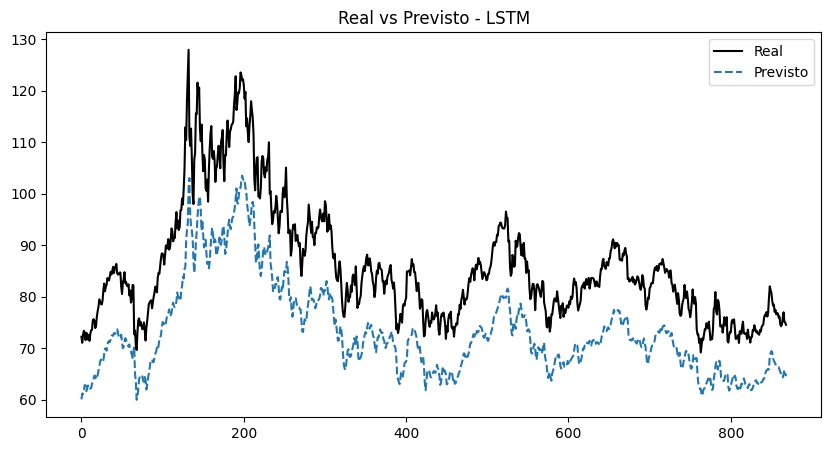


📅 Previsão para os próximos 7 dias:
Dia 1: 74.73
Dia 2: 74.38
Dia 3: 74.68
Dia 4: 75.83
Dia 5: 76.94
Dia 6: 75.25
Dia 7: 74.95


In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 🔹 Baixar os dados históricos do Brent Crude Oil
brent_data = yf.Ticker("BZ=F")
brent_df = pd.DataFrame(brent_data.history(period="max"))

# 🔹 Ajustar a data para remover a hora e resetar índice
brent_df.reset_index(inplace=True)
brent_df['Date'] = brent_df['Date'].dt.strftime('%Y-%m-%d')

# 🔹 Selecionar colunas de interesse
brent_df = brent_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 🔹 Criar target (preço de fechamento do próximo dia)
brent_df['Target'] = brent_df['Close'].shift(-1)

# 🔹 Remover NaN gerado pelo shift
brent_df.dropna(inplace=True)

# 🔹 Estatísticas Descritivas
print("\n📊 Estatísticas Descritivas:")
print(brent_df.describe())

# 🔹 Detectar e corrigir outliers usando o método do IQR
def remove_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Aplicar a remoção de outliers nas variáveis numéricas
brent_df = remove_outliers(brent_df, ['Open', 'High', 'Low', 'Close', 'Volume'])

# 🔹 Adicionar Features Derivadas
brent_df['Moving_Avg_5'] = brent_df['Close'].rolling(window=5).mean()
brent_df['Moving_Avg_10'] = brent_df['Close'].rolling(window=10).mean()
brent_df['Std_Dev_5'] = brent_df['Close'].rolling(window=5).std()
brent_df['Daily_Change'] = brent_df['Close'].pct_change() * 100

# Substituir NaN gerado pelas novas features
brent_df.dropna(inplace=True)

# 🔹 Visualização da Matriz de Correlação
plt.figure(figsize=(8, 6))
sns.heatmap(brent_df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Variáveis")
plt.show()

# 🔹 Selecionar variáveis relevantes
X = brent_df[['Open', 'High', 'Low', 'Close', 'Moving_Avg_5', 'Moving_Avg_10', 'Std_Dev_5']]
y = brent_df['Target']

# 🔹 Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Exibir período de treino e teste
train_start_date = brent_df.iloc[:len(X_train)]['Date'].min()
train_end_date = brent_df.iloc[:len(X_train)]['Date'].max()
test_start_date = brent_df.iloc[len(X_train):]['Date'].min()
test_end_date = brent_df.iloc[len(X_train):]['Date'].max()

print(f"\n📅 Período de Treino: {train_start_date} a {train_end_date}")
print(f"📅 Período de Teste: {test_start_date} a {test_end_date}")

# 🔹 Definir modelos de ML
models = {
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Regressão Linear": LinearRegression(),
}

# 🔹 Criar modelo LSTM com Dropout
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# 🔹 Função para treinar e avaliar modelos
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ajustar tamanho caso necessário
    min_length = min(len(y_test), len(y_pred))
    y_test, y_pred = y_test[:min_length], y_pred[:min_length]

    # Calcular métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"🔹 Modelo: {model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2%}\n")

    # Criar gráfico de comparação
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label="Real", color="black")
    plt.plot(y_pred, label="Previsto", linestyle="dashed")
    plt.legend()
    plt.title(f"Real vs Previsto - {model_name}")
    plt.show()

    return {"MAE": mae, "RMSE": rmse, "R2": r2, "pred": y_pred}

# 🔹 Avaliar modelos clássicos
print("\n➡️ Avaliação dos Modelos de Machine Learning:")
results = {name: train_and_evaluate(model, X_train, X_test, y_train, y_test, name) for name, model in models.items()}

# 🔹 Treinar e avaliar LSTM
print("\n➡️ Treinando LSTM...")
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ajustar tamanho se necessário
min_length = min(len(y_test), len(y_pred_lstm))
y_test, y_pred_lstm = y_test[:min_length], y_pred_lstm[:min_length]

r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"\n🔹 Modelo: LSTM")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.2%}\n")

# Criar gráfico para LSTM
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black")
plt.plot(y_pred_lstm, label="Previsto", linestyle="dashed")
plt.legend()
plt.title("Real vs Previsto - LSTM")
plt.show()

# 🔹 Previsão para os próximos 7 dias
last_7_days = X_test.iloc[-7:]
predictions_next_7_days = models["Regressão Linear"].predict(last_7_days)

print("\n📅 Previsão para os próximos 7 dias:")
for i, pred in enumerate(predictions_next_7_days, 1):
    print(f"Dia {i}: {pred:.2f}")